In [459]:
# Import PyTorch
import torch
from torch import nn
import pandas as pd
import torch.nn.functional as F
import numpy as np

# Import torchvision 
import torchvision
from torchvision import datasets, models
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.optim import lr_scheduler

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import time
from tempfile import TemporaryDirectory

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.7.1
torchvision version: 0.22.1


In [460]:
class SHAPDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        # Read the CSV file
        self.data = pd.read_csv(csv_file)
        # Store the root directory where the images are located
        self.root_dir = root_dir
        # Store the transformation to be applied
        self.transform = transform
        # Get the columns for image paths and labels
        self.image_paths = self.data['image_path']
        # Corrected typo from 'labesl' to 'labels'      
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(self.data['label'].unique()))}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}
        self.labels = self.data['label'].map(self.label_to_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Use os.path.join to create the full path to the image
        img_name = self.image_paths.iloc[idx]
        img_path = os.path.join(self.root_dir, img_name)
        
        # Open the image
        image = Image.open(img_path).convert('RGB')
        
        # Get the label
        label = torch.tensor(int(self.labels.iloc[idx]), dtype=torch.long)
        
        # Apply the transformation if it exists
        if self.transform:
            image = self.transform(image)
        
        # Return the transformed image and the label
        return image, label

# ---------------------------------------------------------------------
# DATA LOADING
# ---------------------------------------------------------------------

# Define transformations
transform_original = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ROOT_DIR = ""
original_dataset = SHAPDataset(csv_file="shap_data.csv", root_dir=ROOT_DIR, transform=transform_original)
augmented_dataset = SHAPDataset(csv_file="shap_data.csv", root_dir=ROOT_DIR, transform=transform_augmented)
full_dataset = torch.utils.data.ConcatDataset([original_dataset, augmented_dataset])

# Split the dataset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of testing batches: {len(test_dataloader)}")

Number of training samples: 278
Number of testing samples: 70
Number of training batches: 9
Number of testing batches: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


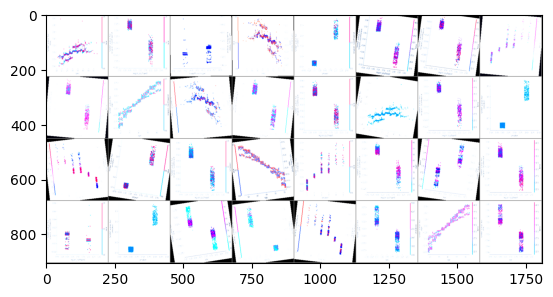

BMI 20-30 clustered x: [20, 30] y: [-0.4, -0.2], BMI 15-50 clustered x: [15, 50] y: [-0.2, 0], BMI 30-40 clustered x: [30, 40] y: [0, 0.2], binary color: blue for 0, red for 1 Southwest 0 clustered x: [0] y: [0, 0.05], Southwest 1 clustered x: [1] y: [-0.1, -0.05], binary color: blue for 0, red for 1 Northwest 0 clustered x: [0] y: [0, 0.02], Northwest 1 clustered x: [1] y: [-0.02, 0] BMI 20-30 clustered x: [20, 30] y: [-0.4, -0.2], BMI 15-50 clustered x: [15, 50] y: [-0.2, 0.1], BMI 30-40 clustered x: [30, 40] y: [0.1, 0.3], binary color: blue for 0, red for 1 Smoker 0 clustered x: [0] y: [-0.5, 0], Smoker 1 clustered x: [1] y: [1, 1.5], binary color: blue for 0, red for 1 Southeast 0 clustered x: [0] y: [0, 0.04], Southeast 1 clustered x: [1] y: [-0.1, -0.02], color gradient: blue for low BMI, red for high BMI Southwest 0 clustered x: [0] y: [0, 0.05], Southwest 1 clustered x: [1] y: [-0.01, -0.025], color gradient: blue for low BMI, red for high BMI Children 0 clustered x: [0] y: [-

In [461]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
idx_to_label = original_dataset.idx_to_label

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{idx_to_label[labels[j].item()]}' for j in range(BATCH_SIZE)))

In [462]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(weights=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

num_classes = len(set(original_dataset.labels))
net = Net(num_classes).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [463]:
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [464]:
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 3 == 2:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 3:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     3] loss: 4.250
[1,     6] loss: 3.616
[1,     9] loss: 3.371
[2,     3] loss: 2.715
[2,     6] loss: 2.490
[2,     9] loss: 2.281
[3,     3] loss: 1.951
[3,     6] loss: 1.782
[3,     9] loss: 1.747
[4,     3] loss: 1.726
[4,     6] loss: 1.344
[4,     9] loss: 1.384
[5,     3] loss: 1.294
[5,     6] loss: 1.188
[5,     9] loss: 1.193
[6,     3] loss: 1.045
[6,     6] loss: 0.918
[6,     9] loss: 1.066
[7,     3] loss: 0.747
[7,     6] loss: 0.831
[7,     9] loss: 0.942
[8,     3] loss: 0.690
[8,     6] loss: 0.722
[8,     9] loss: 0.623
[9,     3] loss: 0.664
[9,     6] loss: 0.509
[9,     9] loss: 0.549
[10,     3] loss: 0.556
[10,     6] loss: 0.512
[10,     9] loss: 0.397
[11,     3] loss: 0.410
[11,     6] loss: 0.458
[11,     9] loss: 0.407
[12,     3] loss: 0.265
[12,     6] loss: 0.320
[12,     9] loss: 0.493
[13,     3] loss: 0.341
[13,     6] loss: 0.230
[13,     9] loss: 0.226
[14,     3] loss: 0.234
[14,     6] loss: 0.329
[14,     9] loss: 0.292
[15,     3] loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


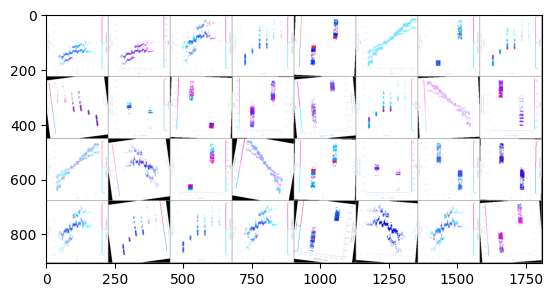

GroundTruth:  BMI 20-30 clustered x: [20, 30] y: [-0.4, -0.2], BMI 15-50 clustered x: [15, 50] y: [-0.2, 0], BMI 30-40 clustered x: [30, 40] y: [0, 0.2], binary color: blue for 0, red for 1 BMI 20-30 clustered x: [20, 30] y: [-0.4, -0.2], BMI 15-50 clustered x: [15, 50] y: [-0.2, 0], BMI 30-40 clustered x: [30, 40] y: [0, 0.2], color gradient: blue for low age, red for high age BMI 20-30 clustered x: [20, 30] y: [-0.4, -0.2], BMI 15-50 clustered x: [15, 50] y: [-0.2, 0.1], BMI 30-40 clustered x: [30, 40] y: [0.1, 0.3], binary color: blue for 0, red for 1 Children 0 clustered x: [0] y: [-0.2, 0], Children 1 clustered x: [1] y: [0, 0.1], Children 2 clustered x: [2] y: [0.1, 0.2], Children 3 clustered x: [3] y: [0.1, 0.2], binary color: blue for 0, red for 1 Sex 0 clustered x: [0] y: [0.02, 0.08], Sex 1 clustered x: [1] y: [-0.08, 0], binary color: blue for 0, red for 1 Increasing linear trend, age 20-40 below 0 x: [20, 40] y: [-1, 0], age 40-60 above 0 x: [40, 60] y: [0, 0.75] Smoker 0 c

In [465]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{idx_to_label[labels[j].item()]}' for j in range(24)))

In [466]:
PATH = '.graph_analyzer.pth'
torch.save(net.state_dict(), PATH)

In [469]:
torch.save(net.state_dict(), 'best_model.pth')

In [467]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 87 %


In [468]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {100 * correct // total} %')

Accuracy of the network on the train images: 100 %


In [ ]:
import torch
from torch import nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# Model
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(weights=None)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Dropout(0.7), nn.Linear(num_ftrs, num_classes))
    def forward(self, x): return self.model(x)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 13  # Adjust to your number of classes
net = Net(num_classes).to(device)
net.load_state_dict(torch.load('best_model.pth'))
net.eval()

# Transforms
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Labels (replace with your idx_to_label)
idx_to_label = {0: "BMI 20-30", 1: "BMI 30-40", 2: "Age 40-50", 3: "Label 3", 4: "Label 4", 5: "Label 5", 6: "Label 6", 7: "Label 7", 8: "Label 8", 9: "Label 9", 10: "Label 10", 11: "Label 11", 12: "Label 12"}

# Predict function
def predict_image(image_path):
    image = transform(Image.open(image_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        output = net(image)
        _, predicted = torch.max(output, 1)
        label = idx_to_label[predicted.item()]
    return label

# Test
image_path = input("Enter image path: ")
print(f"Predicted label: {predict_image(image_path)}")

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(set(full_dataset.labels)))
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 3 == 2:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 3:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
# ... (after defining net, optimizer, criterion)
best_test_loss = float('inf')
patience = 10
for epoch in range(50):  # Start with 50 epochs
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    net.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    test_loss /= len(test_dataloader)
    print(f'Epoch {epoch + 1}, Train Loss: {running_loss / len(train_dataloader):.3f}, Test Loss: {test_loss:.3f}')

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(net.state_dict(), 'best_model.pth')
    else:
        if epoch > patience and test_loss > min(test_losses[-patience:]) if test_losses else True:
            print(f'Early stopping at epoch {epoch + 1}')
            net.load_state_dict(torch.load('best_model.pth'))
            break

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(weights=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)